In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, H_no, E_no, I_no, sub_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        self.sub_no = sub_no
        self.E_no = E_no
        self.I_no = I_no
        
        self.E_scale = nn.Parameter(torch.zeros(self.E_no), requires_grad=True)
        self.I_scale = nn.Parameter(torch.zeros(self.I_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
            
        self.C_syn_e_raw = nn.Parameter(torch.zeros(sub_no, E_no))
        self.C_syn_i_raw = nn.Parameter(torch.zeros(sub_no, I_no))
        
        self.V_o = nn.Parameter(torch.zeros(1), requires_grad=True)
        
    def forward(self, S_e, S_i, temp):
        T_data = S_e.shape[1]
        batch_size = S_e.shape[0]
        S_e = S_e * torch.exp(self.E_scale.reshape(1,1,-1))
        S_i = S_i * torch.exp(self.I_scale.reshape(1,1,-1))*(-1)
        
        C_syn_e = F.softmax(self.C_syn_e_raw/temp, 0)
        C_syn_i = F.softmax(self.C_syn_i_raw/temp, 0)
        
        S_e_sub = torch.matmul(S_e, C_syn_e.T.unsqueeze(0))
        S_i_sub = torch.matmul(S_i, C_syn_i.T.unsqueeze(0))
        S_sub = S_e_sub + S_i_sub
        
        sub_out = torch.zeros(batch_size, T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            rnn_out, _ = self.rnn[s](S_sub[:,:,s].unsqueeze(2))
            lin_out = self.linear[s](rnn_out.reshape(-1,self.H_no)).reshape(batch_size, T_data)
            sub_out[:,:,s] = sub_out[:,:,s] + lin_out     
        final = torch.sum(sub_out, 2) + self.V_o
        
        return final, sub_out, C_syn_e, C_syn_i


In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "rand"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "V_diff.npy"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 650 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 10
sub_no = 8
E_no = 2000
I_no = 200
device = torch.device("cuda")

batch_length = 50000
batch_size = 5
iter_no = 9750
epoch_no = iter_no*batch_length*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(H_no, E_no, I_no, sub_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.9)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

23008


In [7]:
temp_list = np.logspace(0.5,-3,50)
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (i%25 == 24) & (temp_count < 49):
        temp_count += 1
    temp = temp_list[temp_count]
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _, _, _ = model(batch_E_neural, batch_I_neural, temp)
    
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0), 0.0001)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-7-82a0938b40f7>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.004492 2.30625
49 0.03271 2.176604
99 0.343072 1.47852
149 0.197987 2.724863
199 0.209539 3.141249
249 0.103116 4.118007
299 0.377448 4.607814
349 0.54851 3.548083
399 0.598475 2.378324
449 0.610635 2.328348
499 0.716494 1.688331
549 0.646991 1.709007
599 0.740467 1.158662
649 0.773062 0.753445
699 0.830002 0.434635
749 0.848347 0.360217
799 0.87594 0.27986
849 0.838479 0.377068
899 0.887273 0.253811
949 0.875242 0.300312
999 0.869541 0.293401
1049 0.896656 0.236398
1099 0.902883 0.247821
1149 0.914204 0.196842
1199 0.917369 0.202346
1249 0.939045 0.139353
1299 0.923109 0.173815
1349 0.918489 0.189715
1399 0.921139 0.198776
1449 0.919564 0.218687
1499 0.921024 0.196687
1549 0.91043 0.242802
1599 0.895034 0.334146
1649 0.901152 0.329372
1699 0.897244 0.337359
1749 0.904176 0.3355
1799 0.906428 0.323804
1849 0.909234 0.303619
1899 0.882027 0.408009
1949 0.907425 0.391124



KeyboardInterrupt: 

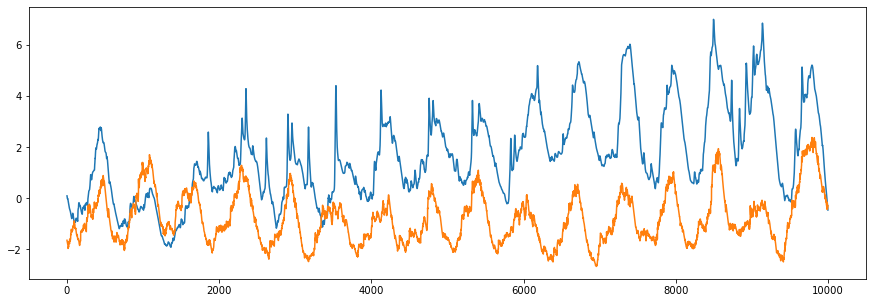

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[6000:16000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000])

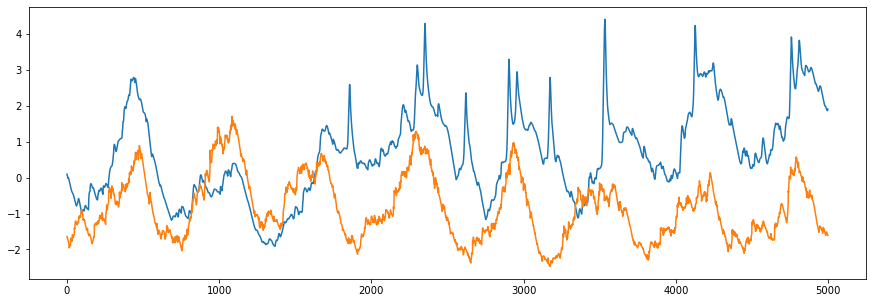

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[6000:16000][:5000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000][:5000])

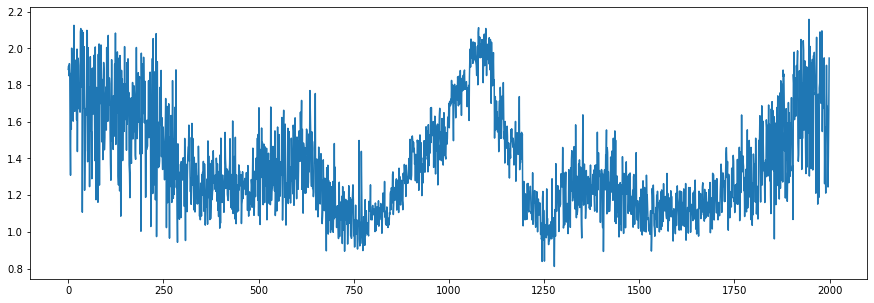

In [11]:
plt.figure(figsize = (15,5))
plt.plot(np.exp(model.E_scale.cpu().detach().numpy()))

In [12]:
C_syn_e_plot = np.zeros((E_no))

for i in range(E_no):
    idx = torch.argmax(model.C_syn_e_raw[:,i])
    C_syn_e_plot[i] = idx

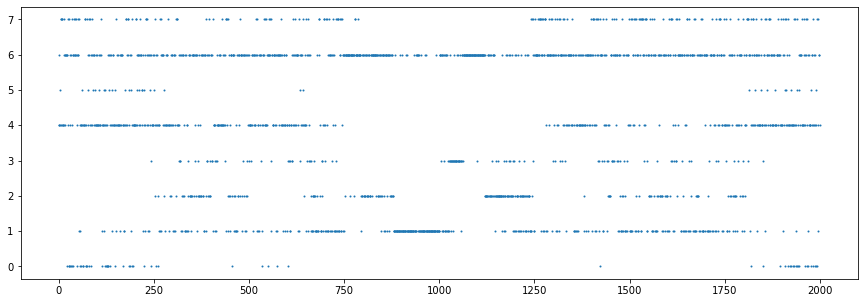

In [17]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), C_syn_e_plot, s=1)

(array([ 62., 359., 205.,   0., 121., 348.,   0.,  36., 676., 193.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

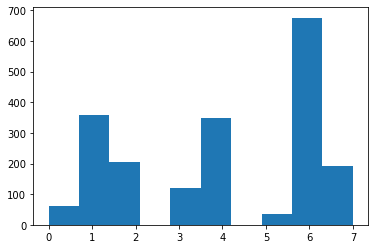

In [14]:
plt.hist(C_syn_e_plot)